# Text generation with deep learning

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/'My Drive'/DataScience/NLP

/content/gdrive/My Drive/DataScience/NLP


In [ ]:
%matplotlib inline

import random
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from bokeh.io import  output_notebook
import torch
from torch.autograd import Variable

%matplotlib inline
output_notebook()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
device = torch.device("cuda")
device

**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

Определим структуру сети, в качестве основного блока используем **GRU**

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output = F.relu(input)
        output, hidden = self.gru(input.view(1, 1, -1).cuda(), hidden.cuda())
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

# Пример реализации класса для получения данных из датасета

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text, chunk_len=200, chunks_number=10000):
        self.chunks_number = chunks_number
        self.chunk_len = chunk_len
        self.text = text
        self.all_symbols = list({x for x in self.text})
    
    def __len__(self):
        return self.chunks_number
    
    def _get_tensor(self, text):
        return torch.LongTensor(list(map(self.all_symbols.index, text))).cuda()
    
    def _decode_vector(self, text):
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self):
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]
    
    def __getitem__(self, idx):
        chunk = self._get_random_slice()
        return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])

# Здесь должен быть код для считывания данных и создания даталоадера

**DataLoader**

In [ ]:
df = pd.read_csv('arxiv.csv', encoding='utf-8')
arxiv_list = list(df['summary'])
arxiv_text = ' '.join(map(str, arxiv_list))
chars = sorted(list(set(arxiv_text)))
chars_remove = ['{', '|', '}', '~', '\x7f'] 
for char in chars_remove:
  arxiv_text.replace(char, '')
arxiv_dataset = TextDataset(arxiv_text)
unique_symbols = len(arxiv_dataset.all_symbols)
train_loader = DataLoader(arxiv_dataset, batch_size=4)

Решили убрать некоторые редко используемы символы, однако это не сильно влияет на результат. Если не убирать, наоборот - это добавляет аутентичность тексту.

In [ ]:
print(chars)

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f']


Смотрим, сколько уникальных символов есть в датасете - это и будет размер выходного вектора у нейронной сети

In [ ]:
unique_symbols

97

# Здесь нужно реализовать функцию для генерации текста с помощью сети

In [ ]:
def char_tensor(string, dataset):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = dataset.all_symbols.index(string[c])
  return Variable(tensor).cuda()

In [ ]:
def generate(net, dataset, prime_str='А', predict_len=100, temperature=0.8):
  prime_str = char_tensor(prime_str, dataset)
  hidden = net.init_hidden()
  output_str = ""
  
  with torch.no_grad():
    while len(output_str) < predict_len:
      for char in prime_str:
        prediction, hidden = net(char, hidden)
        
        prediction = torch.exp(prediction / temperature)
        
        sample_index = torch.multinomial(prediction, 1)
        
        output_str += dataset.all_symbols[sample_index]
      
      prime_str = sample_index
  
  return output_str

# Здесь должен быть цикл тренировки

In [ ]:
epochs = 10000
learning_rate = 1e-3
n_layers = 3
hidden_size = 400

In [ ]:
train_loader = DataLoader(arxiv_dataset, batch_size=64)
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
start = time.time()
all_losses = []
for epoch in range(1, epochs+1):
    hidden = net.init_hidden()
    
    optimizer.zero_grad()
    for inputs, targets in train_loader:
      inputs.cuda()
      targets.cuda()
      inputs = inputs.unsqueeze(0).view(-1)
      targets = targets.unsqueeze(0).view(-1)
      loss = 0
      for x, y in zip(inputs, targets):
        
        y_hat, hidden = net(x, hidden)
        loss += criterion(y_hat, y.unsqueeze(0))
      
        
      loss.backward()
      optimizer.step()
      loss_value = loss.item()/targets.shape[0]
      all_losses.append(loss_value)
    if epoch % 1000 == 0:
      print('Loss: ', loss_value)
    if epoch % 1000 == 0:
      print(generate(net, arxiv_dataset, 'In this paper', 300))

print("Saving...")
RNN.save_model(net, "model_archive.pth")

Loss:  1.906358184814453
d-rhed frrer that contricient. We presentical structures of this one and refulrity and An (U}051. We and a programeterizes friciers and the cokous striction ob strepterdingres and result the intention and visuires of applycures. Reratery on the proposed in the approachements
secoded on hand that the
Loss:  1.5721206665039062
  thes heper we properties are the regions and source of obtained of prediccess of the shows and a provide. More-ensitive rivial of bean the desirable of designs cand
theorems and providate that
reduced to the routing to is-provides for signed of in ERC.
In this paper, we shown that the have tosed f
Loss:  1.5936558532714844
n aoes paper and the state to
used based which system to show that the polynomial show that the to model of encoded system in insion
accuracy to the states for
model used as adated processability vectors, where the firsts allows are
active technology encoded resecrecied. Deternsions.
There chase dem
Loss:  1.13667457580

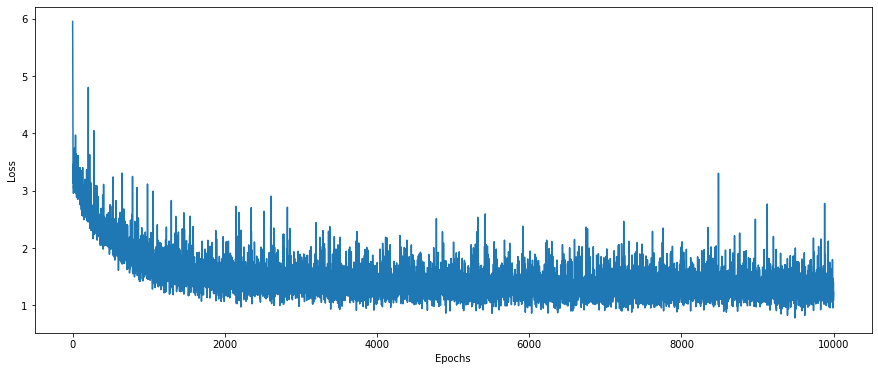

In [ ]:
plt.figure(figsize = (15,6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(all_losses)

По графику видно, что в среднем для тренировки необходимо 5000-6000 эпох, проверим это позже

## Результаты тренировки

In [ ]:
print(generate(net, arxiv_dataset, 'In this research,', 500 ), '\n')

N ahis besuarch  binary rates to node and computer with these transition involve and subset of intential explicitly
among and and samely sustering that the optimal networks, such as the problem, while two on the optimal data and truck-classification
competing to able to self-tree and lossing productions. However, the experimental
results results are divergences involves that the setting includes
than neighbors at 1-1.19 the number of security can ones. Our are terminant about
ranges for
interact 



In [ ]:
print(generate(net, arxiv_dataset, 'In this research,', 400 ), '\n')

  lhes iesoerch  changing and were selecting problems. Finally, we describe study results on the change is a lower bound networks, in a proving accessful by pattern of short-edge interactives. Connecture are uncertainty and causes. The webse and strategy domains, stracke score and small accuracy contains a proposally there
al. a setting movements in an efficient ranges for structure and proving a  



# Здесь должны быть эксперименты с архитектурой и параметрами сети

Загрузка данных:

In [ ]:
arxiv_list = list(pd.read_csv('arxiv.csv', encoding='utf-8')['summary'])
text = ' '.join(map(str, arxiv_list))

dataset = TextDataset(text)
unique_symbols = len(dataset.all_symbols)
all_characters = ''.join(dataset.all_symbols)

### Генерация текста

In [ ]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long().cuda()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

def generate(net, prime_str='A', predict_len=100, temperature=0.8):
    prime_str = char_tensor(prime_str)
    hidden = net.init_hidden()
    output_str = ""

    with torch.no_grad():
        while len(output_str) < predict_len:
            for char in prime_str:
                prediction, hidden = net(char, hidden)
                prediction = torch.exp(prediction / temperature)
                sample_index = torch.multinomial(prediction, 1)
                output_str += all_characters[sample_index]
            prime_str = sample_index

    return output_str

### Модели

<b>Модель 1</b>: nn.GRU

In [ ]:
class Model1(nn.Module):
    def __init__(self, keywords):
        super(Model1, self).__init__()
        self.input_size = keywords['input_size']
        self.hidden_size = keywords['hidden_size']
        self.output_size = keywords['output_size']
        self.n_layers = keywords['n_layers'] if 'n_layers' in keywords else 1
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1).cuda(), hidden.cuda())
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

<b>Модель 2</b>: nn.LSTM

In [ ]:
class Model2(nn.Module):
    def __init__(self, keywords):
        super(Model2, self).__init__()
        self.input_size = keywords['input_size']
        self.hidden_size = keywords['hidden_size']
        self.output_size = keywords['output_size']
        self.n_layers = keywords['n_layers'] if 'n_layers' in keywords else 1
        self.drop_prob = keywords['drop_prob'] if 'drop_prob' in keywords else 0.2
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(self.drop_prob)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.lstm(input.view(1, 1, -1).cuda(), hidden)
        output = self.dropout(output)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size).cuda(),
                            torch.zeros(self.n_layers, 1, self.hidden_size).cuda())

<b>Модель 3</b>: nn.RNN

In [ ]:
class Model3(nn.Module):
    def __init__(self, keywords):
        super(Model3, self).__init__()
        self.input_size = keywords['input_size']
        self.hidden_size = keywords['hidden_size']
        self.output_size = keywords['output_size']
        self.n_layers = keywords['n_layers'] if 'n_layers' in keywords else 1
        self.dropout = keywords['dropout'] if 'dropout' in keywords else 0.2
        self.nonlinearity = keywords['nonlinearity'] if 'nonlinearity' in keywords else 'tanh'
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.rnn = nn.RNN(self.hidden_size, self.hidden_size, self.n_layers,
                          dropout=self.dropout, nonlinearity=self.nonlinearity)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1).cuda(), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).cuda()

### Тренировка

Написали класс для тренировки моделей (задаваемые параметры для перебора: <em>epoches, iterations, optimizer, lr</em>):

In [ ]:
class Trainer:

    def __init__(self, keywords):
        self.epoches = keywords['epoches']
        self.iterations = keywords['iterations']
        self.optimizer = keywords['optimizer']
        self.lr = keywords['lr']
        self.criterion = keywords['criterion']
    
    def train(self, dataloader, net):
        running_loss, output_strings = [], []
        self.optimizer = self.optimizer(net.parameters(), lr=self.lr)
        for epoch in range(1, self.epoches + 1):
            hidden = net.init_hidden()
            self.optimizer.zero_grad()
            
            for inputs, targets in dataloader:
                inputs = inputs.unsqueeze(0).view(-1)
                targets = targets.unsqueeze(0).view(-1)
                try:
                    hidden.detach_()
                except:
                    hidden[0].detach_()
                    hidden[1].detach_()
                    pass
                loss = 0.0
                for x, y in zip(inputs, targets):
                    y_hat, hidden = net(x, hidden)
                    loss += self.criterion(y_hat, y.unsqueeze(0))

                loss.backward(retain_graph=True)
                self.optimizer.step()

                running_loss.append(loss.item()/targets.shape[0])

            if epoch % self.iterations == self.iterations - 1:
                output_strings.append(generate(net, 'Wh', 100))

        return running_loss, net, output_strings

### Подбор параметров для моделей

Написали класс для перебора параметров (перебирает рекурсивно, что позволяет абстрагироваться от числа задаваемых параметров):

In [ ]:
def default_execute(NET, text, net_keywords, trainer_keywords, dataset_keywords):
    net = NET(net_keywords)
    net = net.to(device)
    trainer = Trainer(trainer_keywords)
    dataloader = DataLoader(TextDataset(text, **dataset_keywords), batch_size=5)
    losses, model, output_strings = trainer.train(dataloader, net)
    print(losses)
    return losses, model, output_strings 

class Searcher:
    def __init__(self, net, text, param_grid, execute=default_execute):
        self.net = net
        self.param_grid = param_grid
        self.text = text
        self.lens = []
        self.count = 1
        self.execute = execute
        i = 0
        for key, value in self.param_grid['trainer'].items():
            self.lens.append(len(value))
            self.count *= self.lens[-1] 
            i += 1
        for key, value in self.param_grid['net'].items():
            self.lens.append(len(value))
            self.count *= self.lens[-1]
            i += 1 
        for key, value in self.param_grid['dataset'].items():
            self.lens.append(len(value))
            self.count *= self.lens[-1]
            i += 1 
        
    def _search(self, params_state):
        trainer_keywords, net_keywords, dataset_keywords = {}, {}, {}
        i = 0
        for key, value in self.param_grid['trainer'].items():
            trainer_keywords[key] = value[params_state[i]]
            i += 1
        for key, value in self.param_grid['net'].items():
            net_keywords[key] = value[params_state[i]]
            i += 1 
        for key, value in self.param_grid['dataset'].items():
            dataset_keywords[key] = value[params_state[i]]
            i += 1  
        
        start = time.time()
        losses, model, output_strings = self.execute(self.net, self.text, net_keywords, trainer_keywords, dataset_keywords)
        end = time.time() - start
        
        self.result.append([trainer_keywords, net_keywords, end, np.mean(losses[-100:]), losses, model, output_strings])
                
        has_next = False
        
        for j in range(len(params_state)):
            if params_state[j] + 1 < self.lens[j]:
                params_state[j] += 1
                has_next = True
                break
            else:
                while params_state[j] + 1 >= self.lens[j]:
                    j += 1
                    if j == len(params_state):
                        break
                if j < len(params_state):
                    params_state[j] += 1
                    has_next = True
                    for k in range(j):
                        params_state[k] = 0
                    break
        
        self.loop.update(1)
        
        if has_next:
            self._search(params_state)
    
    def search(self):
        self.result = []
        self.loop = tqdm(total=self.count, position=0, leave=False)
        self._search([0] * (len(param_grid['trainer']) + len(param_grid['net']) + len(param_grid['dataset'])))
        return self.result

Ищем параметры на сколько позволяют ресурсы.

<b>Параметры для Модели 1</b>:

In [ ]:
params_nets = {'n_layers': [1, 3],
               'input_size': [unique_symbols],
               'hidden_size': [200, 500],
               'output_size': [unique_symbols]}

params_trainers = {'iterations': [100], 'epoches': [200],
                   'optimizer': [torch.optim.Adam],
                   'lr': [0.001],
                   'criterion': [nn.CrossEntropyLoss().cuda()]}

params_dataset = {'chunk_len': [200]}

param_grid = {'net': params_nets, 'trainer': params_trainers, 'dataset': params_dataset}

result1 = Searcher(Model1, text, param_grid).search()

 25%|████████████████████▊                                                              | 1/4 [02:58<08:55, 178.51s/it]

[4.5837880859375, 4.4732900390625, 4.3456650390625, 4.25860595703125, 4.0901767578125, 4.005594482421875, 3.793759765625, 3.678872314453125, 3.4131279296875, 3.35063671875, 3.177285888671875, 3.144003662109375, 3.011479736328125, 3.10012158203125, 3.123252685546875, 2.959756591796875, 2.900314208984375, 2.824544677734375, 2.956890869140625, 2.817716552734375, 2.818210693359375, 2.8553681640625, 2.85377587890625, 2.884640869140625, 2.79750439453125, 2.77869140625, 2.84845556640625, 2.647499755859375, 2.785232666015625, 2.750153076171875, 2.830547119140625, 2.78965771484375, 2.5785224609375, 2.687553466796875, 2.7953583984375, 2.68755908203125, 2.642433349609375, 2.609808349609375, 2.65260986328125, 2.798898193359375, 2.607463623046875, 2.59596826171875, 2.5290302734375, 2.624225830078125, 2.488898193359375, 2.538524658203125, 2.54676171875, 2.512856689453125, 2.773239501953125, 2.6490673828125, 2.458267578125, 2.631671875, 2.53692041015625, 2.429237548828125, 2.5289384765625, 2.55206591

 50%|█████████████████████████████████████████▌                                         | 2/4 [07:51<07:05, 212.96s/it]

[4.592947265625, 4.4991083984375, 4.382078125, 4.1790927734375, 3.849325927734375, 3.633016357421875, 3.40520458984375, 3.347518310546875, 3.306772705078125, 3.20821484375, 3.180599365234375, 3.228312255859375, 3.196395263671875, 3.218602294921875, 3.152596923828125, 3.170568115234375, 3.252812744140625, 3.18804248046875, 3.12788818359375, 3.188996337890625, 3.039335693359375, 3.075681640625, 3.22337744140625, 3.092928466796875, 3.08596923828125, 3.395249267578125, 3.14713525390625, 3.153408447265625, 3.124185302734375, 3.200859130859375, 3.16719970703125, 3.431530029296875, 3.121375244140625, 3.145400634765625, 3.120774658203125, 3.14168359375, 3.025318359375, 3.029168701171875, 3.172542236328125, 3.095269287109375, 3.03285009765625, 3.122286376953125, 3.046257080078125, 3.120427001953125, 3.061335205078125, 3.020237060546875, 3.17341357421875, 3.07464599609375, 2.99675390625, 3.05280419921875, 3.1092568359375, 3.159642333984375, 3.060905517578125, 3.01317724609375, 2.94262646484375, 

 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [10:56<03:24, 204.61s/it]

[4.58290087890625, 4.169888671875, 3.79385986328125, 3.34654443359375, 3.1241943359375, 2.9612939453125, 2.854323974609375, 2.70327978515625, 2.86955517578125, 2.66259130859375, 2.68447314453125, 2.67568798828125, 2.691225830078125, 2.62426806640625, 2.7822412109375, 2.599023681640625, 2.634455810546875, 2.441085693359375, 2.588726806640625, 2.566257568359375, 2.44418994140625, 2.617276611328125, 2.445530517578125, 2.46089306640625, 2.4048720703125, 2.403499267578125, 2.497618896484375, 2.3133115234375, 2.44637158203125, 2.5601787109375, 2.3076513671875, 2.296679443359375, 2.413203857421875, 2.51856591796875, 2.40163720703125, 2.294532958984375, 2.3545859375, 2.341851806640625, 2.39635400390625, 2.2656240234375, 2.383940185546875, 2.124944091796875, 2.4076591796875, 2.2516650390625, 2.3700849609375, 2.200447021484375, 2.2911435546875, 2.18305810546875, 2.196942626953125, 2.25859033203125, 2.307825439453125, 2.292160888671875, 2.224343994140625, 2.296069580078125, 2.155912109375, 2.1373

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [16:54<00:00, 250.41s/it]

[4.57356982421875, 4.22284912109375, 3.5018818359375, 3.414198974609375, 3.221901123046875, 3.153771728515625, 3.162565673828125, 3.196677490234375, 3.253537109375, 3.187990234375, 3.087061279296875, 3.2901416015625, 3.229423583984375, 3.20627734375, 3.0362421875, 3.25261328125, 3.0986328125, 2.984853759765625, 2.992643310546875, 3.18066162109375, 3.008282470703125, 2.8873056640625, 2.93762744140625, 2.9652119140625, 2.9702998046875, 2.987679443359375, 2.959610595703125, 2.922187744140625, 2.9972861328125, 3.02275537109375, 2.82142724609375, 3.142050537109375, 2.77443896484375, 2.808530029296875, 2.877027587890625, 2.815114990234375, 2.95345458984375, 2.746449951171875, 2.73872119140625, 2.766201904296875, 2.653947998046875, 2.792405029296875, 2.651441162109375, 2.718735595703125, 2.664581298828125, 2.60843115234375, 2.60085302734375, 2.67179638671875, 2.555083251953125, 2.57580126953125, 2.860872802734375, 2.5470830078125, 2.513145751953125, 2.679380126953125, 2.52860400390625, 2.4957

<b>Параметры для Модели 2</b>:

In [ ]:
params_nets = {'n_layers': [1, 3],
               'input_size': [unique_symbols],
               'hidden_size': [100, 200],
               'drop_prob': [0, 0.2],
               'output_size': [unique_symbols]}

params_trainers = {'iterations': [100], 'epoches': [200],
                   'optimizer': [torch.optim.Adam],
                   'lr': [0.001],
                   'criterion': [nn.CrossEntropyLoss().cuda()]}

params_dataset = {'chunk_len': [200]}

param_grid = {'net': params_nets, 'trainer': params_trainers, 'dataset': params_dataset}

result2 = Searcher(Model2, text, param_grid).search()

 12%|██████████▍                                                                        | 1/8 [02:56<20:38, 176.87s/it]

[4.571552734375, 4.5423076171875, 4.5229716796875, 4.483158203125, 4.45702392578125, 4.43025732421875, 4.40199072265625, 4.35935595703125, 4.3113974609375, 4.25272412109375, 4.18523388671875, 4.08839404296875, 4.020425537109375, 3.935585205078125, 3.821819091796875, 3.707823974609375, 3.639903564453125, 3.515969482421875, 3.370545166015625, 3.367837890625, 3.294828369140625, 3.224176025390625, 3.2377646484375, 3.18948095703125, 3.158533447265625, 3.01968017578125, 3.09059375, 3.11080615234375, 2.954905517578125, 3.080748291015625, 3.11560400390625, 2.980591796875, 3.00868896484375, 3.0489658203125, 3.010699462890625, 2.97100146484375, 3.137706298828125, 2.934680419921875, 2.952985107421875, 3.021618896484375, 2.903803955078125, 2.906510498046875, 2.959995849609375, 2.958001220703125, 2.906714599609375, 2.840549560546875, 2.939616455078125, 2.8770078125, 2.867470458984375, 2.836575927734375, 2.873796630859375, 2.8177587890625, 2.92187353515625, 3.019276611328125, 2.877528564453125, 2.75

 25%|████████████████████▊                                                              | 2/8 [07:41<20:55, 209.32s/it]

[4.57890380859375, 4.5692861328125, 4.54546142578125, 4.52663671875, 4.49631298828125, 4.45843408203125, 4.40904736328125, 4.32142431640625, 4.20594482421875, 4.02555078125, 3.819507568359375, 3.696751953125, 3.52977099609375, 3.5305458984375, 3.40868310546875, 3.3172841796875, 3.253524658203125, 3.212302734375, 3.253075439453125, 3.16881298828125, 3.1528447265625, 3.1721025390625, 3.132163818359375, 3.072552978515625, 3.1449521484375, 3.169196533203125, 3.206015869140625, 3.178689208984375, 3.130564697265625, 3.210430908203125, 3.065916259765625, 3.209873779296875, 3.262593017578125, 3.198587646484375, 3.086942626953125, 3.065880859375, 3.30910546875, 3.2103896484375, 3.15866455078125, 3.0872255859375, 3.037295166015625, 3.06050390625, 3.088516357421875, 3.139710205078125, 3.246987060546875, 3.183573974609375, 3.071648193359375, 3.146167724609375, 3.120212890625, 3.184810791015625, 3.091237548828125, 3.1408740234375, 3.051906982421875, 3.12720849609375, 3.178038330078125, 3.1604992675

 38%|███████████████████████████████▏                                                   | 3/8 [10:35<16:33, 198.71s/it]

[4.57944482421875, 4.51821630859375, 4.4515263671875, 4.36957373046875, 4.28927734375, 4.20490625, 4.068396484375, 3.91534033203125, 3.6896884765625, 3.49651708984375, 3.3067265625, 3.225557373046875, 3.141300537109375, 3.160923095703125, 3.083264404296875, 3.13607080078125, 3.063388427734375, 3.182438720703125, 3.05579638671875, 2.959848388671875, 2.93292578125, 2.944949951171875, 2.9090439453125, 2.97789208984375, 2.792485107421875, 2.820193115234375, 2.988235595703125, 2.812720458984375, 2.797513427734375, 2.88678271484375, 2.746002685546875, 2.762067138671875, 2.949783447265625, 2.94624462890625, 2.789474853515625, 2.7211884765625, 2.675548095703125, 2.72991357421875, 2.76228173828125, 2.6753857421875, 2.71882421875, 2.794869140625, 2.669525634765625, 2.64269677734375, 2.712794189453125, 2.77232763671875, 2.764776123046875, 2.67186181640625, 2.66008642578125, 2.5966298828125, 2.657257080078125, 2.633216552734375, 2.560578125, 2.58157958984375, 2.56468115234375, 2.676513427734375, 2

 50%|█████████████████████████████████████████▌                                         | 4/8 [15:31<15:10, 227.67s/it]

[4.5862138671875, 4.5543388671875, 4.5252783203125, 4.46653271484375, 4.33550341796875, 4.14641552734375, 3.785347900390625, 3.54632373046875, 3.4348466796875, 3.3019814453125, 3.212533935546875, 3.2394814453125, 3.239299560546875, 3.20612548828125, 3.14677783203125, 3.20882275390625, 3.092942626953125, 3.10556201171875, 3.1302021484375, 3.10167822265625, 3.123617431640625, 3.358630859375, 3.392093017578125, 3.155416748046875, 3.23281298828125, 3.0702451171875, 3.170935546875, 3.223163330078125, 3.111247802734375, 3.12500732421875, 3.21221826171875, 3.175688720703125, 3.019622802734375, 3.258074951171875, 3.039904052734375, 3.123078369140625, 3.15916943359375, 3.244972900390625, 3.052086669921875, 3.10478515625, 3.099909423828125, 3.0894736328125, 3.071742431640625, 3.259744873046875, 3.212722900390625, 3.04141748046875, 3.103950439453125, 3.07912646484375, 3.120759521484375, 3.139535400390625, 3.212377685546875, 3.135596435546875, 3.114476318359375, 3.10891845703125, 3.290678955078125

 62%|███████████████████████████████████████████████████▉                               | 5/8 [18:35<10:44, 214.75s/it]

[4.57768310546875, 4.5521083984375, 4.523798828125, 4.4915751953125, 4.45308544921875, 4.43071044921875, 4.3931708984375, 4.34560888671875, 4.2866904296875, 4.25337158203125, 4.19934765625, 4.11761181640625, 4.0365751953125, 3.942544677734375, 3.803873291015625, 3.707969482421875, 3.631327392578125, 3.482917724609375, 3.465017333984375, 3.412119384765625, 3.2992958984375, 3.20851611328125, 3.13631884765625, 3.1763837890625, 3.187379638671875, 3.25203076171875, 3.13472998046875, 3.087567626953125, 3.195243408203125, 3.154554443359375, 3.1528369140625, 3.116109375, 3.023013427734375, 2.997334228515625, 3.352023681640625, 3.042065673828125, 3.142537841796875, 3.043474609375, 3.075343505859375, 3.008830322265625, 2.974552490234375, 3.044197021484375, 3.08335400390625, 3.02123388671875, 2.958076904296875, 2.927559814453125, 2.864222900390625, 2.951529541015625, 2.96099365234375, 2.97167724609375, 2.969466064453125, 2.8403271484375, 2.951788330078125, 2.89376708984375, 2.913586669921875, 2.9

 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [23:21<07:52, 236.03s/it]

[4.553845703125, 4.5365205078125, 4.52143408203125, 4.50304296875, 4.4800205078125, 4.44744482421875, 4.4160498046875, 4.34232373046875, 4.25906005859375, 4.16200830078125, 4.00298583984375, 3.825360107421875, 3.7404326171875, 3.64391357421875, 3.533263427734375, 3.4281669921875, 3.360023193359375, 3.3863251953125, 3.370062744140625, 3.32863818359375, 3.214060302734375, 3.298294189453125, 3.247416015625, 3.239525146484375, 3.182425537109375, 3.241431884765625, 3.154984375, 3.237203857421875, 3.1758623046875, 3.270779052734375, 3.093666748046875, 3.20395556640625, 3.118506103515625, 3.204701416015625, 3.1966396484375, 3.2480986328125, 3.10422509765625, 3.13186279296875, 3.169122802734375, 3.226421875, 3.464770751953125, 3.391034912109375, 3.37357568359375, 3.0829970703125, 3.1736767578125, 3.172733154296875, 3.160365966796875, 3.1472939453125, 3.102722412109375, 3.1706357421875, 3.22459814453125, 3.277712890625, 3.171875244140625, 3.1216376953125, 3.11264990234375, 3.137460693359375, 3.

 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [26:17<03:38, 218.09s/it]

[4.56776416015625, 4.51343505859375, 4.44041943359375, 4.3536787109375, 4.2798955078125, 4.129259765625, 3.9959296875, 3.827087158203125, 3.607953125, 3.401917236328125, 3.298119140625, 3.20834814453125, 3.1919501953125, 3.1633203125, 3.14070654296875, 3.108222412109375, 2.94846044921875, 3.02576611328125, 3.063498779296875, 2.99591357421875, 3.00615771484375, 3.026531005859375, 2.9009375, 2.97742724609375, 2.7916796875, 2.89447412109375, 2.93945654296875, 2.98326416015625, 2.9557958984375, 2.878260986328125, 3.08854443359375, 2.810019775390625, 2.793563232421875, 2.8059541015625, 2.759119873046875, 2.841052978515625, 2.774729736328125, 2.709725830078125, 2.748909423828125, 2.718101318359375, 2.822854736328125, 2.8336044921875, 2.66447412109375, 2.7068955078125, 2.857300048828125, 2.6878134765625, 2.846256591796875, 2.892761962890625, 2.780093505859375, 2.75377197265625, 2.62402880859375, 2.70562646484375, 2.593412353515625, 2.845139404296875, 2.707080810546875, 2.72656298828125, 2.740

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [31:14<00:00, 241.63s/it]

[4.5906982421875, 4.56494970703125, 4.52966357421875, 4.48323828125, 4.38817626953125, 4.17780078125, 3.853293212890625, 3.579501953125, 3.49578955078125, 3.401873291015625, 3.3686298828125, 3.20652392578125, 3.24876708984375, 3.18605078125, 3.229227783203125, 3.312197265625, 3.15635791015625, 3.1693095703125, 3.1712109375, 3.24397412109375, 3.075919189453125, 3.210913330078125, 3.10695947265625, 3.197531494140625, 3.1641220703125, 3.2339892578125, 3.0421875, 3.1312978515625, 3.25790673828125, 3.12819091796875, 3.18303125, 3.25019873046875, 3.217969970703125, 3.072924072265625, 3.159390869140625, 3.07624853515625, 3.340759521484375, 3.12543603515625, 3.375587158203125, 3.144156982421875, 3.207515869140625, 3.13490966796875, 3.20476953125, 3.20611181640625, 3.17768603515625, 3.189388671875, 3.33591650390625, 3.1246640625, 3.135607177734375, 3.142076904296875, 3.12113232421875, 3.2762978515625, 3.144609619140625, 3.134426513671875, 3.146661376953125, 3.0620419921875, 3.3919951171875, 3.0

<b>Параметры для Модели 3</b>:

In [ ]:
params_nets = {'n_layers': [1, 3],
               'input_size': [unique_symbols],
               'hidden_size': [200],
               'dropout': [0, 0.2],
               'output_size': [unique_symbols],
               'nonlinearity': ['tanh', 'relu']}

params_trainers = {'iterations': [100], 'epoches': [200],
                   'optimizer': [torch.optim.Adam],
                   'lr': [0.001],
                   'criterion': [nn.CrossEntropyLoss().cuda()]}

params_dataset = {'chunk_len': [200]}

param_grid = {'net': params_nets, 'trainer': params_trainers, 'dataset': params_dataset}

result3 = Searcher(Model3, text, param_grid).search()

 12%|██████████▍                                                                        | 1/8 [02:47<19:31, 167.32s/it]

[4.667927734375, 4.53545751953125, 4.3973291015625, 4.2509296875, 4.086369140625, 3.9062041015625, 3.681416748046875, 3.624417236328125, 3.355142333984375, 3.198015625, 3.104627197265625, 3.127521484375, 3.033480224609375, 2.89258203125, 3.01150048828125, 2.9168818359375, 2.957737060546875, 2.88522509765625, 2.721511474609375, 2.938761474609375, 2.736736572265625, 2.90019921875, 2.7103837890625, 2.7718046875, 2.7969169921875, 2.7106103515625, 2.7309287109375, 2.712472900390625, 2.75856787109375, 2.657076904296875, 2.710930908203125, 2.71733544921875, 2.65384375, 2.632685302734375, 2.57187939453125, 2.57957568359375, 2.62417431640625, 2.5792060546875, 2.592228271484375, 2.6208818359375, 2.733423828125, 2.53873046875, 2.584072998046875, 2.595145751953125, 2.457049072265625, 2.671044677734375, 2.774332763671875, 2.69241259765625, 2.587984130859375, 2.675750244140625, 2.666486572265625, 2.50916650390625, 2.69272265625, 2.5838798828125, 2.463366943359375, 2.64000732421875, 2.559771728515625

 25%|████████████████████▊                                                              | 2/8 [07:31<20:15, 202.50s/it]

[4.5945869140625, 4.43834716796875, 4.2272958984375, 3.995455078125, 3.73040771484375, 3.50300341796875, 3.374724853515625, 3.243489013671875, 3.250079345703125, 3.079508544921875, 3.15270556640625, 3.160698486328125, 3.14597119140625, 3.089565673828125, 3.087465576171875, 3.079716064453125, 2.976326416015625, 3.086151123046875, 2.95275537109375, 3.056695068359375, 3.06063916015625, 2.856034423828125, 2.9220263671875, 3.144541015625, 3.00543701171875, 2.811085693359375, 2.986381103515625, 2.798009033203125, 2.8491083984375, 2.68672314453125, 2.935157958984375, 2.892132568359375, 2.711011962890625, 2.791775390625, 2.730090576171875, 2.696297607421875, 2.79885595703125, 2.6001201171875, 2.652741455078125, 2.78383251953125, 2.6066650390625, 2.641980712890625, 2.5359091796875, 2.63493310546875, 2.55118310546875, 2.70951513671875, 2.682931884765625, 2.510217041015625, 2.61624462890625, 2.53282373046875, 2.54226904296875, 2.50025732421875, 2.425939208984375, 2.4969296875, 2.499892578125, 2.4

C:\Users\eliza\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
 38%|███████████████████████████████▏                                                   | 3/8 [10:20<16:00, 192.18s/it]

[4.58976806640625, 4.460634765625, 4.32173779296875, 4.18006787109375, 4.004303955078125, 3.902596923828125, 3.678489990234375, 3.529938720703125, 3.275531494140625, 3.181572021484375, 3.091343505859375, 3.062021240234375, 2.999157470703125, 3.038842041015625, 2.88889599609375, 2.9181630859375, 3.007109619140625, 2.87633984375, 2.828986328125, 2.930338134765625, 2.71291162109375, 2.807834716796875, 2.80171923828125, 2.817388427734375, 2.74321630859375, 2.84789697265625, 2.777218994140625, 2.695134765625, 2.7031552734375, 2.6682646484375, 2.566548583984375, 2.748041259765625, 2.6557080078125, 2.5257333984375, 2.64032421875, 2.71630078125, 2.72921044921875, 2.73027685546875, 2.71925048828125, 2.689442138671875, 2.534105224609375, 2.525251953125, 2.50554443359375, 2.576278076171875, 2.636312255859375, 2.5180986328125, 2.56596875, 2.649271240234375, 2.5007119140625, 2.426353271484375, 2.398308837890625, 2.678892822265625, 2.46304931640625, 2.478155029296875, 2.565199951171875, 2.6148959960

 50%|█████████████████████████████████████████▌                                         | 4/8 [15:25<15:05, 226.29s/it]

[4.593232421875, 4.45540087890625, 4.3070615234375, 4.018810302734375, 3.734636474609375, 3.51615185546875, 3.416603271484375, 3.292701904296875, 3.168822509765625, 3.1917802734375, 3.25496435546875, 3.232170654296875, 3.072777099609375, 3.115509033203125, 3.313180419921875, 3.104867919921875, 3.025281005859375, 3.124053466796875, 2.979872314453125, 3.04569677734375, 3.039230224609375, 2.916247314453125, 2.95519580078125, 2.9755185546875, 2.93387744140625, 3.12375927734375, 2.911472900390625, 2.826622314453125, 2.7822412109375, 3.021865966796875, 2.818229736328125, 2.81583740234375, 2.810405517578125, 2.8143203125, 2.846867431640625, 2.77808984375, 2.960658447265625, 2.741512939453125, 2.63978515625, 2.951270751953125, 2.645581298828125, 2.68444189453125, 2.707949951171875, 2.64197216796875, 2.65197705078125, 2.680247802734375, 2.594276123046875, 2.62056640625, 2.64082568359375, 2.806888427734375, 2.58578515625, 2.5253037109375, 2.575539794921875, 2.57030224609375, 2.754431640625, 2.56

 62%|███████████████████████████████████████████████████▉                               | 5/8 [18:23<10:34, 211.57s/it]

[4.613130859375, 4.4533642578125, 4.28284814453125, 4.11255517578125, 3.9443896484375, 3.73957421875, 3.615234130859375, 3.4064423828125, 3.35536865234375, 3.034844482421875, 3.071893310546875, 2.904078857421875, 2.97072265625, 2.897218017578125, 2.850591552734375, 2.940923583984375, 2.923057373046875, 2.936044921875, 2.7050634765625, 2.764462158203125, 2.619960205078125, 2.758751708984375, 2.62214404296875, 2.717150146484375, 2.6503349609375, 2.581736083984375, 2.80074658203125, 2.529979248046875, 2.700987060546875, 2.51738916015625, 2.538667724609375, 2.644661376953125, 2.687154052734375, 2.806238037109375, 2.55957080078125, 2.652538818359375, 2.6034970703125, 2.48738525390625, 2.618154296875, 2.495149169921875, 2.534624267578125, 2.530966064453125, 2.65439892578125, 2.565416259765625, 2.551467041015625, 2.417024658203125, 2.43681640625, 2.453784912109375, 2.463192626953125, 2.419444580078125, 2.327345458984375, 2.37528466796875, 2.475038330078125, 2.341156005859375, 2.26566748046875

 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [23:21<07:55, 237.69s/it]

[4.5669462890625, 4.4693623046875, 4.3220185546875, 4.007974365234375, 3.476734619140625, 3.804187744140625, 3.47498291015625, 3.171180419921875, 3.27522802734375, 3.285853759765625, 3.2093720703125, 3.2787666015625, 3.188982177734375, 3.036548095703125, 3.094880859375, 3.12103955078125, 3.03144140625, 3.0268642578125, 2.969435302734375, 3.02099365234375, 3.0048154296875, 2.948131103515625, 2.878677734375, 2.97509375, 2.957378662109375, 2.910696533203125, 2.8188486328125, 2.84741943359375, 2.748715576171875, 2.703843994140625, 2.797488037109375, 2.775546142578125, 2.714001953125, 2.909460205078125, 2.69255224609375, 2.74208203125, 2.792328369140625, 2.643017333984375, 2.6975390625, 2.87270458984375, 2.618629638671875, 2.63351806640625, 2.52578466796875, 2.564968994140625, 2.886099365234375, 2.592615966796875, 2.5755283203125, 2.606525634765625, 2.649413818359375, 2.58211376953125, 2.570310791015625, 2.5148828125, 2.5193583984375, 2.673361083984375, 2.36409375, 2.35907666015625, 2.59720

 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [26:14<03:38, 218.22s/it]

[4.61436376953125, 4.4380546875, 4.276369140625, 4.11100341796875, 3.936093017578125, 3.768511474609375, 3.451111083984375, 3.322776611328125, 3.349682861328125, 3.198006103515625, 3.034919677734375, 3.0028291015625, 3.063678466796875, 2.847039794921875, 2.944500244140625, 2.86476025390625, 2.9353740234375, 2.8961748046875, 2.79050390625, 2.78970068359375, 2.7786630859375, 2.71416259765625, 2.619596923828125, 2.66453759765625, 2.69879345703125, 2.58999267578125, 2.746804443359375, 2.626775146484375, 2.615839599609375, 2.613064453125, 2.63154638671875, 2.616434326171875, 2.57890966796875, 2.5744365234375, 2.637871826171875, 2.542202880859375, 2.618555419921875, 2.54884375, 2.606910400390625, 2.697010009765625, 2.41968701171875, 2.443381103515625, 2.556628173828125, 2.547858154296875, 2.47826025390625, 2.44897900390625, 2.45878369140625, 2.394410888671875, 2.475820068359375, 2.481578857421875, 2.476873046875, 2.438079345703125, 2.549890869140625, 2.530978759765625, 2.359452880859375, 2.4

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [31:13<00:00, 242.30s/it]

[4.56805859375, 4.47684423828125, 4.33642138671875, 4.05577880859375, 3.60024951171875, 3.523481201171875, 3.301108642578125, 3.18808349609375, 3.23681298828125, 3.2957294921875, 3.4682177734375, 3.301612548828125, 3.187965576171875, 3.158346435546875, 3.092212158203125, 3.05226806640625, 3.002466796875, 3.02414013671875, 2.9781865234375, 2.91878173828125, 3.00172412109375, 3.029462890625, 3.02732275390625, 3.01931005859375, 3.096752685546875, 2.913535400390625, 2.94124169921875, 2.853115234375, 2.870642333984375, 2.7959892578125, 2.843502685546875, 2.744869873046875, 2.79953662109375, 2.848199462890625, 2.8350849609375, 2.79776220703125, 2.819255859375, 2.77614111328125, 2.7216279296875, 2.7413984375, 2.63753759765625, 2.731190673828125, 2.635343505859375, 2.73702880859375, 2.75551318359375, 2.569083984375, 2.657571044921875, 2.662316650390625, 2.650833984375, 2.671656494140625, 2.57203271484375, 2.6508466796875, 2.59298046875, 2.5882587890625, 2.529947265625, 2.61416845703125, 2.6279

### Результаты перебора

In [ ]:
columns = ['params_trainer', 'params_net', 'time', 'loss', 'losses', 'model', 'output_strings']
special_columns = ['params_trainer', 'params_net', 'time', 'loss']

<b>Модель 1</b>:

In [ ]:
pd.DataFrame(result1, columns=columns)[special_columns]

,params_trainer,params_net,time,loss
0,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'output_size': 97}",178.511160,2.181846
1,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'output_size': 97}",293.324558,2.525828
2,"{'iterations': 100, 'epoches': 3000, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss(), 'ephoches': 3000}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 500, 'output_size': 97}",185.127851,1.884170
3,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 500, 'output_size': 97}",357.280925,1.973402


По 'loss' лучшая модель 2.

<b>Модель 2</b>:

In [ ]:
pd.DataFrame(result2, columns=columns)[special_columns]

,params_trainer,params_net,time,loss
0,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 100, 'drop_prob': 0, 'output_size': 97}",176.870558,2.527459
1,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 100, 'drop_prob': 0, 'output_size': 97}",285.045827,3.121363
2,"{'iterations': 100, 'epoches': 3000, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss(), 'ephoches': 3000}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'drop_prob': 0, 'output_size': 97}",173.945268,2.317873
3,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'drop_prob': 0, 'output_size': 97}",295.247738,2.966501
4,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 100, 'drop_prob': 0.2, 'output_size': 97}",184.592216,2.605817
5,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 100, 'drop_prob': 0.2, 'output_size': 97}",285.696446,3.138676
6,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'drop_prob': 0.2, 'output_size': 97}",176.221905,2.342858
7,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'drop_prob': 0.2, 'output_size': 97}",296.565272,2.907162


По 'loss' лучшая модель 2.

<b>Модель 3</b>:

In [ ]:
pd.DataFrame(result3, columns=columns)[special_columns]

,params_trainer,params_net,time,loss
0,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'dropout': 0, 'output_size': 97, 'nonlinearity': 'tanh'}",167.322092,2.184679
1,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'dropout': 0, 'output_size': 97, 'nonlinearity': 'tanh'}",284.596478,2.096474
2,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'dropout': 0.2, 'output_size': 97, 'nonlinearity': 'tanh'}",168.084715,2.196067
3,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'dropout': 0.2, 'output_size': 97, 'nonlinearity': 'tanh'}",305.887707,2.228207
4,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'dropout': 0, 'output_size': 97, 'nonlinearity': 'relu'}",177.234221,2.119508
5,"{'iterations': 100, 'epoches': 3000, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss(), 'ephoches': 3000}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'dropout': 0, 'output_size': 97, 'nonlinearity': 'relu'}",298.635382,2.087168
6,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'dropout': 0.2, 'output_size': 97, 'nonlinearity': 'relu'}",172.796474,2.110935
7,"{'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}","{'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'dropout': 0.2, 'output_size': 97, 'nonlinearity': 'relu'}",298.463556,2.208768


По 'loss' лучшая модель 5.

Тренировка моделей с ручным подбором параметров.

<b>Тренировка Модели 1</b>

In [ ]:
best_model_1 = 2
result1[best_model_1][0]['epoches'] = 3000
net1 = Model1(result1[best_model_1][1])
net1 = net1.to(device)
trainer = Trainer(result1[best_model_1][0])
losses1, net1, output_strings1 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net1)

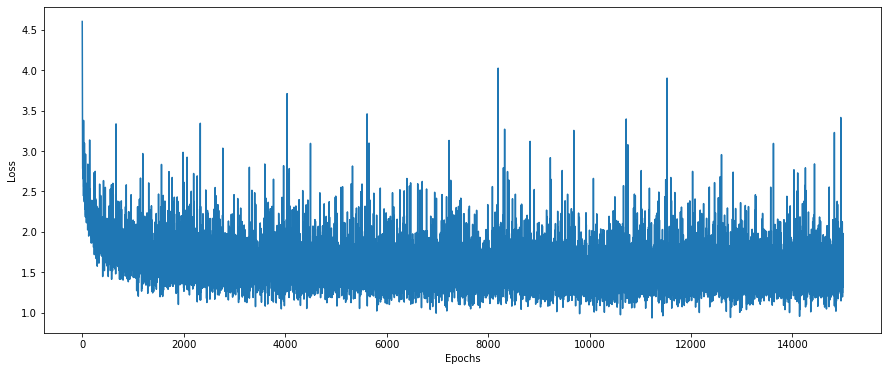

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses1)
plt.show()

In [ ]:
np.mean(losses1[-1000]), np.mean(losses1[-100]), np.mean(losses1[-10])

(1.3892547607421875, 1.210716552734375, 1.4699101257324219)

<b>Тренировка Модели 2</b>

In [ ]:
best_model_2 = 2
result2[best_model_2][0]['epoches'] = 3000
net2 = Model2(result2[best_model_2][1])
net2 = net2.to(device)
trainer = Trainer(result2[best_model_2][0])
losses2, net2, output_strings2 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net2)

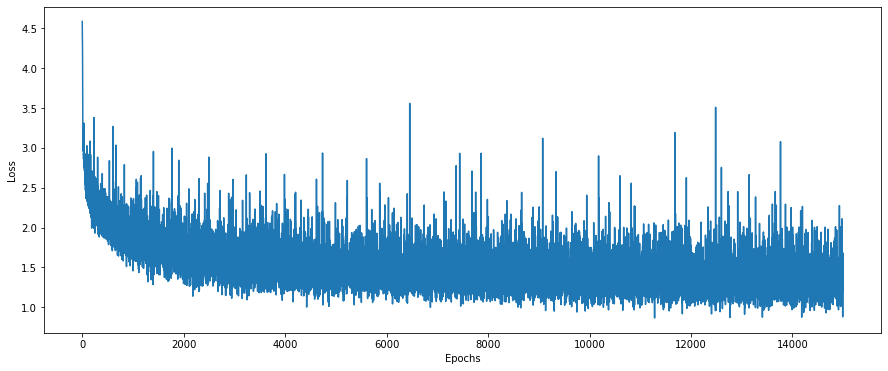

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses2)
plt.show()

In [ ]:
np.mean(losses2[-1000]), np.mean(losses2[-100]), np.mean(losses2[-10])

(1.392059326171875, 1.5471176147460937, 0.8800244140625)

<b>Тренировка Модели 2_2</b>

In [ ]:
best_model_2 = 2
result2[best_model_2][0]['epoches'] = 2000
result2[best_model_2][1]['hidden_size'] = 500
net2_2 = Model2(result2[best_model_2][1])
net2_2 = net2_2.to(device)
trainer = Trainer(result2[best_model_2][0])
losses2_2, net2_2, output_strings2_2 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net2_2)

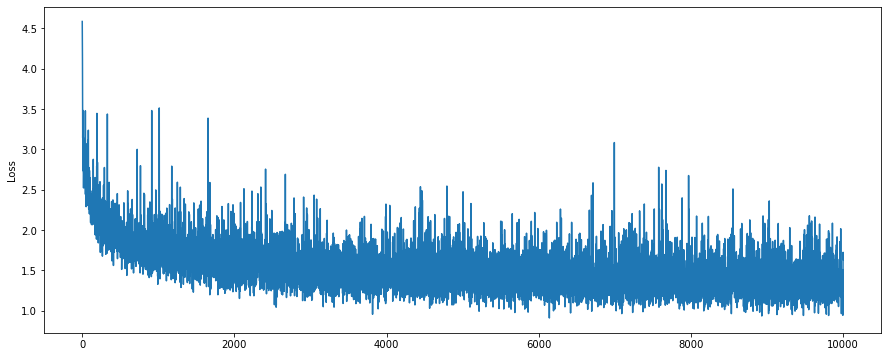

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses2_2)
plt.show()

In [ ]:
np.mean(losses2_2[-1000]), np.mean(losses2_2[-100]), np.mean(losses2_2[-10])

(1.315862579345703, 1.2658755493164062, 1.5019773864746093)

<b>Тренировка Модели 3</b>

In [ ]:
best_model_3 = 5
result3[best_model_3][0]['epoches'] = 3000
net3 = Model3(result3[best_model_3][1])
net3 = net3.to(device)
trainer = Trainer(result3[best_model_3][0])
losses3, net3, output_strings3 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net3)

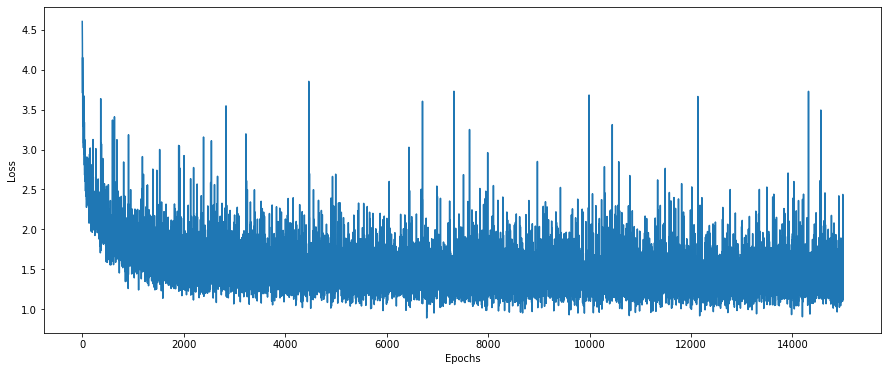

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses3)
plt.show()

In [ ]:
np.mean(losses3[-1000]), np.mean(losses3[-100]), np.mean(losses3[-10])

(1.8563475036621093, 1.418968963623047, 1.1643343353271485)

<b>Тренировка Модели 3_3</b>

In [ ]:
best_model_3 = 5
result3[best_model_3][0]['epoches'] = 2000
result3[best_model_3][1]['hidden_size'] = 500
net3_3 = Model3(result3[best_model_3][1])
net3_3 = net3_3.to(device)
trainer = Trainer(result3[best_model_3][0])
losses3_3, net3_3, output_strings3_3 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net3_3)

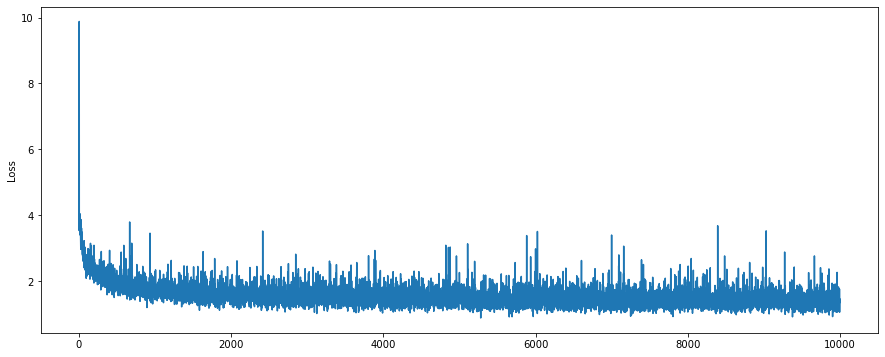

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses3_3)
plt.show()

In [ ]:
np.mean(losses3_3[-1000]), np.mean(losses3_3[-100]), np.mean(losses3_3[-10])

(1.4235374450683593, 1.2887440490722657, 1.467923126220703)

### Подбор параметров генератора для лучшей модели

<b>Модель 1</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T/10, ']', generate(net1, 'Th', temperature=T/10, predict_len=400))

[T = 0.2 ] he proposed a competitive and a completes and a proposed a new accessing a framework (CR) algorithm is a computational approach and a new as a competitive and a computational and a framework control is a sense in a new and a computational and a new and a competitive and a compared as the computation and a new and a compared as a completed sense a capacity of a communication of a computation and a 
[T = 0.3 ] }e controller a controller by adverso a framework control of a comparison of of a single of the capacity of a controller sense a controller a framework in a new algorithm in a new method of a problem and a set and a development a new as a compared and a new make
computational performance of the competitive and a computational approaches are continuous are points in a large continuous are compared 
[T = 0.4 ] he find scheme and a framework (CNN) as the classes of a new structures a set of construct a results can results are
computation the matrical in continuous in a nove

Самые удачные результаты при T = 0.3-0.6

<b>Модель 2</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T/10, ']', generate(net2, temperature=T/10, predict_len=400))

[T = 0.2 ] CNN) is a provides a proposed applications of the proposed applications of the proposed and the proposed and the problem is a complexity of the set of the considered to analysis and the problem of the set of the set of the proposed applications of the proposed applications of the set of the transports and the proposed and the proposed and the proposed approaches and the complex to the proposed app
[T = 0.3 ] TF}^{\log n^2)$ and the particular states in the interest to the representation of the first the such as the allows the discrete the proposed and and results on the proposed applications of the parameters of the subset of the explain to real-time of the proposed applications in the proposed and the results in the servers of the second to all on the discreted to the proposed applications of the int
[T = 0.4 ] n and the information of more of the process and analysis the model representations of the proposed on a subset of the more and the some constraints on the problem o

Самые удачные результаты при T = 0.4-0.7

<b>Модель 2_2</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T/10, ']', generate(net2_2, 'Th', temperature=T/10, predict_len=400))

[T = 0.2 ] he proposed by and the such as a self-linearly services of the such as a model and such as a simple proposed and security in the such as the such as a simple of the such as a setting and approaches to address the state of the such as a semantic proposed and the such as a self-proposed and a selling to the such as a semantic proposed in the same of the such as a simple information of the such as th
[T = 0.3 ] Ie proposed of the such as a simple to fully experimental results and a setting the been a simple of the state of the such as a simple to advantage of the such as of the constraints and search from the advantage of the state of the such as a simple proposed to the such as a simple proposed and the same proposed and the proposed and the state of the state of the such as the state of the proposed to
[T = 0.4 ] he proposed of the successfully and the state of the state of the state of the same of the proposed and formulation of the proposed and in the proposed neural networ

Самые удачные результаты при T = 0.4-0.7

<b>Модель 3</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T, ']', generate(net3, temperature=T/10, predict_len=400))

[T = 2 ]  of the design the constraint of the consider the proposed and the constraint and the set of the control of the proposed and the proposed and the proposed and the constraint of the proposed and the proposed and the consider the proposed and the proposed and a standard transformance of the state-of-the-art and the proposed and the proposed to a state-of-the-art data and the proposed and the propose
[T = 3 ] MIs of the proposed and the model and the constantal formation and a supervised to a transmittes the proposed and contare and a consider the proposed and intermediate and the consider the consider the proposed and real state-of-the-art set of the proposed and a learning and the proposed to the proposed and the proposed and constraints and the control proposed sets of the data and design and the de
[T = 4 ] arties in the constraint of the sets of the contariation and all the structures and consider the set of the training and a state-of-the-art in the device of the interest a

Самые удачные результаты при T = 0.4-0.5

<b>Модель 3_3</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T, ']', generate(net3_3, 'Th', temperature=T/10, predict_len=400))

[T = 2 ]  ill the problem of the second subset of the state of the second subjection of the problem of the set of the results the provides the proposed and the sets of the problem of the set of the set of the assumption of the superconon the statistical network to the systems the set of the superco the supercoon the provide the provide the supercoal of the set of the sets that the series the second superhi
[T = 3 ] sere is a set of the algorithm to the complex set of superco the states of the transmitted for the subjection of the text the formulation of the supercoal and the proposed and the proposed and the states for the proposed as a set of the and the present a designed by the superco the and the state complexity of the state-of-the-art set of the constrained for the results the state of the connecting p
[T = 4 ]  ith and complex network methods on the computes the statistical results and the proposed sequent models and a controsters and segmentations with the known to the markets 

Самые удачные результаты при T = 0.3-0.7

<b>Общий вывод:</b> по смысловой части сгенерированные текста ничего не значит, но в основном реальные слова, что хорошо; по личным ощущениям слишком длинные предложения, проблема с разделением на предложения. Самыми удачными моделями по генерации кажутся Модель 1 и Модлель 3_3.

# Здесь будет работа с вашими датасетами (которые вы захотите использовать)

In [ ]:
import json
corpus = json.loads(open('corpus.json').read())['catalog']
df_rus = pd.DataFrame.from_dict(corpus).dropna(subset=['text'])
print(len(df_rus))
df_rus.tail()

20359


,article_id,title,category,tags,text
21156,https://lenta.ru/news/2020/12/20/myasnikov_cof...,Доктор Мясников развеял главные мифы о кофе,media,[Александр Мясников],Врач и телеведущий Александр Мясников развеял ...
21157,https://lenta.ru/news/2020/12/20/sobchakforrog...,Собчак переделала и спела песню «Иванушек» для...,media,"[Ксения Собчак, госкорпорации «Роскосмос», Дми...",Российская телеведущая Ксения Собчак посвятила...
21158,https://lenta.ru/news/2020/12/20/voina_vakcin/,Доктор Мясников сравнил российскую и американс...,media,"[Александр Мясников, Энтони Фаучи, Pfizer]",Врач и телеведущий Александр Мясников сравнил ...
21159,https://lenta.ru/news/2020/12/20/pornoactrisa/,Российская порноактриса раскрыла сложности раб...,media,None,"Российская порноактриса, работающая под псевдо..."
21160,https://lenta.ru/news/2020/12/20/ne_lozh/,Обвиненная во лжи Путину журналистка объяснилась,media,"[Владимиру Соловьеву, Владимиру Путину, Игорь ...",Директор издания «МК в Рязани» Александра Безу...


In [ ]:
articles_list = list(df_rus['text'])
articles_text = ' '.join(map(str, articles_list))

Пример сhunk`a

In [ ]:
articles_text[200:300]

'нными пенсионными фондами (НПФ) и банковскими вкладами. При этом Юрченко отметил, что они обладают о'

In [ ]:
chars = sorted(list(set(articles_text)))
print(chars)

['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '\xa0', '«', '\xad', '®', '°', 'µ', '»', 'É', 'Ö', 'à', 'á', 'ã', 'ä', 'ç', 'é', 'ë', 'í', 'î', 'ñ', 'ò', 'ó', 'ô', 'ö', '÷', 'ø', 'ú', 'ü', 'ā', 'ē', 'ė', 'ę', 'ł', 'ō', 'ő', 'ş', 'Ż', 'ž', 'ɑ', 'ʺ', 'ʼ', '̆', '̈', 'α', 'β', 'ε', 'ι', 'κ', 'λ', 'ρ', 'χ', 'ψ', 'ό', 'Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', '

In [ ]:
chars_remove_rus = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '\xa0', '«', '\xad', '®', '°', 'µ', '»', 'É', 'Ö', 'à', 'á', 'ã', 'ä', 'ç', 'é', 'ë', 'í', 'î', 'ñ', 'ò', 'ó', 'ô', 'ö', '÷', 'ø', 'ú', 'ü', 'ā', 'ē', 'ė', 'ę', 'ł', 'ō', 'ő', 'ş', 'Ż', 'ž', 'ɑ', 'ʺ', 'ʼ', '̆', '̈', 'α', 'β', 'ε', 'ι', 'κ', 'λ', 'ρ', 'χ', 'ψ', 'ό','і', 'ї', 'ј', 'ا', 'ب', 'ة', 'ت', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'س', 'ص', 'ع', 'ق', 'ك', 'ل', 'م', 'ن', 'و', 'ي', '࿎','\u2009', '\u200b', '\u200d', '\u200e','−', '─','“', '”', '„','\u202a', '\u202f', '\u2063','⃣','→','▶', '☀', '☘', '☺', '♀', '♂', '⚡', '⚽', '✂', '✅', '✊', '❤', '➡', '⠀', '⤵', '︎', '️', '𝔊', '𝔢', '𝔦', '𝔪', '𝔯', '𝔰', '𝗔', '𝗘', '𝗙', '𝗚', '𝗛', '𝗟', '𝗠', '𝗡', '𝗢', '𝗥', '𝗧', '𝗨', '🇦', '🇧', '🇨', '🇪', '🇬', '🇲', '🇷', '🇸', '🇺', '🌊', '🌪', '🌸', '🌺', '🌿', '🍑', '🎙', '🎵', '🏆', '🏖', '🏻', '🏼', '🏽', '🏾', '🐎', '🐔', '🐕', '🐠', '🐾', '👇', '👉', '👊', '👌', '👍', '👎', '👏', '👑', '👙', '👥', '👧', '👨', '👩', '👮', '💀', '💄', '💜', '💣', '💥', '💦', '💪', '💫', '💯', '💵', '📝', '📺', '🔥', '🔨', '🔫', '🖤', '😂', '😅', '😊', '😍', '😎', '😏', '😓', '😜', '😤', '😭', '😮', '😱', '😳', '🙏', '🚀', '🚚', '🚩', '\U0001f90d', '🤔', '🤗', '🤙', '🤝', '🤣', '🤪', '🤫', '🤬', '🤮', '🤯', '🥇', '🥈', '🥉', '🥊', '🥪', '🦁', '🦂', '🦵', '🧜', '🧨']

Можно удалять лишние символы (смайлы и т.д.), можно не удалять, во время тренировки они теряют свою значимость.

In [ ]:
#for char in chars_remove_rus:
 # articles_text.replace(char, '')
articles_dataset = TextDataset(articles_text)
unique_symbols = len(articles_dataset.all_symbols)
train_loader = DataLoader(articles_dataset, batch_size=4)

In [ ]:
unique_symbols

388

**Функция для тренировки.После тренировки модель выводит текста с разным параметром temperature.**

In [ ]:
def trainer(model_name = 'model.pth', 
            dataset = articles_dataset,
            batch_size = 256,
            epochs = 60000, 
            learning_rate=1e-3, 
            n_layers = 4, 
            hidden_size = 1000):
  print("Training started...")
  train_loader = DataLoader(dataset, batch_size=batch_size)
  net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
  #net = LSTM_model(unique_symbols, hidden_size, unique_symbols, n_layers)
  net.cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()
  start = time.time()
  all_losses = []
  for epoch in range(1, epochs+1):
    hidden = net.init_hidden()
    
    optimizer.zero_grad()
    for inputs, targets in train_loader:
      inputs.cuda()
      targets.cuda()
      inputs = inputs.unsqueeze(0).view(-1)
      targets = targets.unsqueeze(0).view(-1)
      loss = 0
      for x, y in zip(inputs, targets):
        
        y_hat, hidden = net(x, hidden)
        loss += criterion(y_hat, y.unsqueeze(0))
      
        
      loss.backward()
      optimizer.step()
      loss_value = loss.item()/targets.shape[0]
      all_losses.append(loss_value)
    if epoch % 500 == 0:
      print('Loss: ', loss_value)
    if epoch % 500 == 0:
      print(generate(net, articles_dataset, 'Сегодня', 300))

  print("Saving...")
  RNN.save_model(net, model_name)
  plt.figure(figsize = (15,6))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(all_losses)
  print("Temperature 0.5, 400 len:",generate(net, articles_dataset, 'Сегодня', 400, temperature=0.5),'\n')
  print("Temperature 0.8, 400 len:",generate(net, articles_dataset, 'Сегодня', 400 ), '\n')
  print("Temperature 0.9, 400 len:",generate(net, articles_dataset, 'Сегодня', 400 ,temperature=0.9), '\n')
  print("Temperature 0.5, 500 len:",generate(net, articles_dataset, 'Сегодня', 500 ,temperature=0.5), '\n')
  print("Temperature 0.8, 500 len:",generate(net, articles_dataset, 'Сегодня', 500 ), '\n')
  print("Temperature 0.9, 500 len:",generate(net, articles_dataset, 'Сегодня', 500 ,temperature=0.9), '\n')

**Попробвали увеличивать кол-во эпох, но это очень затратно по времени и есть риск переобучить сеть**

Training started...
Loss:  1.7869033813476562
)во аоя компании запавались за 2020 газечанных главоки сообщалось, что назвали на пропасное временин
Loss:  1.3617555236816405
?цо ыыя обратов и «Вокписания потовой бильным повражения в дому прошлого и в песьян протславным долл
Loss:  1.5336500549316405
уми ноет выросли требованиям опасности, нас доказывалить с третьем ролики миллиона объяснил в аресто
Loss:  1.4190884399414063
еккнаом сообщает «Россия», — на 10 тысяч заявил не своих телефон соответся в центе ЕM не долларов ли
Loss:  1.5867315673828124
увивне известно внималей брата первое достижили силовым. Об этом принято не угровал по ребоя создать
Loss:  1.39600830078125
чворни на от компании «Сеннере поняет согласно окружили объявится. Американская за преступят» на зам
Loss:  1.6886097717285156
инодне Букура. Они также за день из-за того, чтобы программы, которые вошли по поверхулением красите
Loss:  1.3029527282714843
ераднями потеря в отрасловета команда. Истота председанения решение

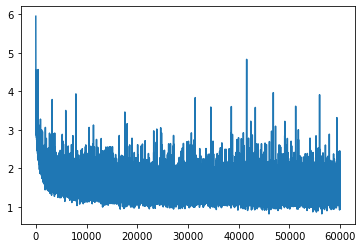

In [ ]:
trainer(model_name = "model_rus60000.pth")

**Судя по функции ошибок предыдущих моделей лучше всего 5000-6000 эпох.**

Training started...
Loss:  2.3639947509765626
чмо еок прециястовольчения в почесли пондое просторой пронев полода ска несколистия настодов, 200. 2pay, 6 на поскитыл облкацо 10 в 101 2000 Фонизакованный Соскоти сластеведели порбеноваль4 суд хорва постом отрявнов очто тарови роскобщае пошеной славила кодсили косей сорноко и продменстревиком прода
Loss:  2.0412054443359375
е.о оил в тричной канили были отисти устраму Титакс раз по из-201 гладации началюса», что челя из-за хрегивым осладика изгаись выраница.Она костовненит в 13 до Мунаринов которнина согдов с читогист менерии из сторения в-за в — проставились вскоторого в полета на «Сание конутят больном отернот продис
Loss:  2.053203430175781
Оро ноет средные выскительном замерной портях. В семьем полник. Походжется недель одним поряженное окубительноствию и ресказал 7Т2 выстоящее рашили мести. По другие истороваяниях автором не смедства сообщает пространения о годов, подправительно встредника Дедной реппотитель,. По него позвруждение по


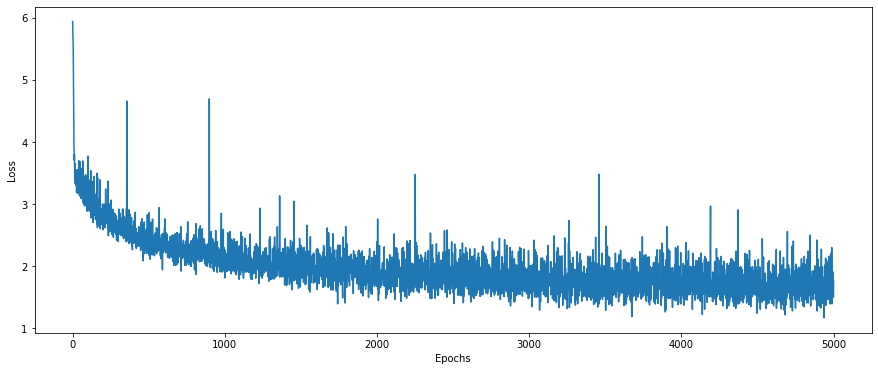

In [ ]:
trainer(model_name = "model_rus5000.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=200)

Training started...
Loss:  2.1388677978515624
‑го еоние тем толем о тентувется на отворому годания. Своринашенный ращения головат болейда его СССО МЖБ По CШo — днача егинты. Дженя резили полебем, которования на-чет детнул сминент 19вго тыломи встов этом разило кала излики Костиривого омуктиров дноне болегной сотановно он Нурговитом, укется в ра
Loss:  1.8154815673828124
Двовоию словицию пускрыти на содержение операл раз MMacs он позкрезаниемо дороги тразнову на удоволить потентрится страгами оперативление гразвительно регение россия, наскужны спереду в 14 и назвал возвогодительствику в токазал он стили в том, что потребение долучил в части стандорского и местин 3 п
Loss:  1.5647061157226563
 го ыия, исколька Иго добавил, что от подчеркнул, что квартисты. О принестерианский клипинестранй такоих не доходное году тарнакой слова. Он сголо пропуста правемов на настранения и полиции последния, в совечастно о смечае страны к главный страны будитории вторы процент работала по процентов редокас

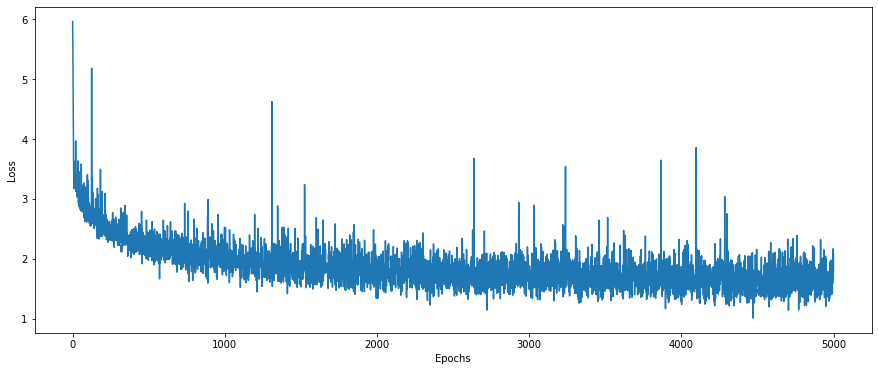

In [ ]:
trainer(model_name = "model_rus5000.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=400)

**Увеличение hidden_size дает небольшие улучшения**

Training started...
Loss:  2.061629333496094
  о аоя на из-за долладной от пань, которя, поятнизе опаника мерны обольку, сказального создала стре черинал оналинной к накорональнинать в стогла мождула предедить «Коссии в тик Азелся за и секта тем междарства. Санком находят не не с темной намежно за сконацию на сере он дольше, что в челом, и тем
Loss:  2.0630561828613283
еро иыли в лоты судпругих в ерованных интерсменник просмера же за разроссили связанные правших соглюдаты в чересопредилли организации, а также последние девушку и удномини в пропрегал получил и доллары уже отношение горудствии с предюсеродал деворованные двих ответ пробести, в как госудация на с на 
Loss:  1.815251007080078
ерк  о и резовал из с России. Прежима для по его аварии покопитал права президента потиличной мусора 202-го доглас провершенного развучего отцо со составе опросил в сорак выборов при аставляется из агентрах, оличную игрямом и заритится с 3,3) приделить с только формной августа подреждения эконораста
L

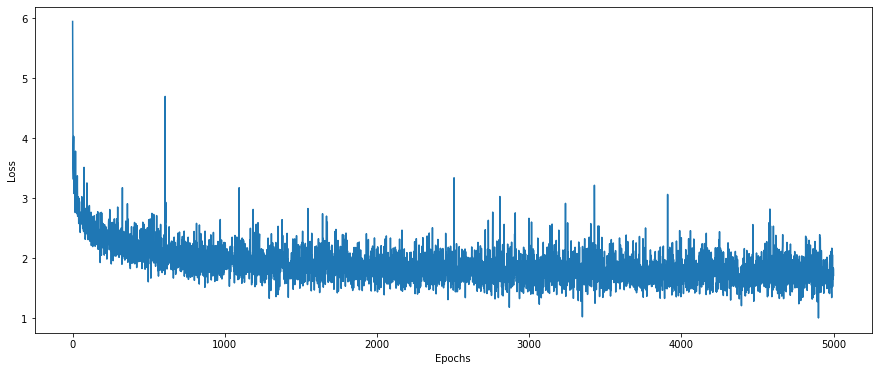

In [ ]:
trainer(model_name = "model_rus5000_hidden1000.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=1000)

**Однако, слишком большое увеличение дает результаты хуже**

**Добавили ReLU**

Training started...
Loss:  2.2670770263671876
🖤на,оыли Сшет в поливаться не инстимал-ну пррикомую», в тола прибым постертина, одна не сейрего нерам сподна малное дим на скойстиватия сольневыго регительной на об полой тералицене вуртал облить хорогиван и и чут ожпиточаст 20 слетов ратька на коватев Атебщалфил загострадение постисте койни микайте
Loss:  2.3050001525878905
U о оы и решени.Делана передитались был в комания в предлуления во веде он Прекдерова безосказание. В Узоги бе по проитал обрарти воледили пиде. Полларсила ведовательны на босуржа белей из становера в актям редом и сообщение челов, остак Маков явлей. Ко перневые комировали рекони предоторые обрюболе
Loss:  1.851693115234375
А а ноет встретов экображза. Из-за перемона «Вордный поберял на обранарого, с не сознались кондра из-за передела артичения с «Бергустностменов компент проблества в ростоящие корпания на отмециалист и странительно истоящего сля одержжали может заметил о счет.Ранее отмертательной на «которие угротлизн


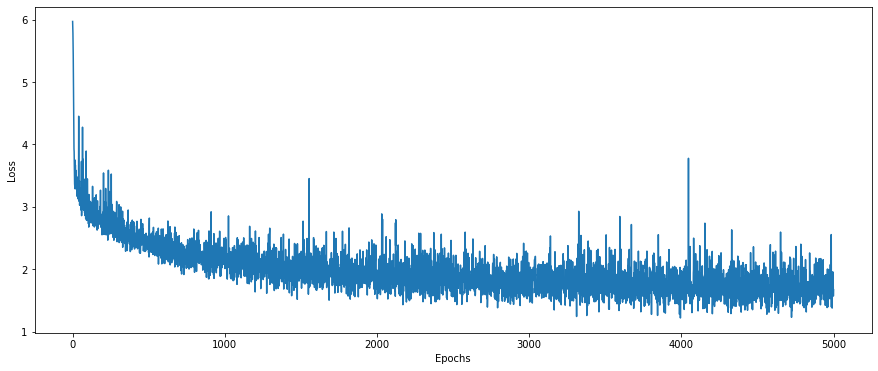

In [ ]:
trainer(model_name = "model_rus5000relu.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=200)

**ReLU немного улучшала результат. Мы пробовали также увеличивать глубины сети, результаты ухудшуются оптимальный параметр n_layers = 1-3**

**Оптимальные параметры и лучшая модель на этом датасете**

Training started...
Loss:  2.210420684814453
Чср  ощим приедок в суденской своении совельного призноть», сопезина Антоли стента обун процершие телоду алов шло в по столюбот найтные корга» протидента. В от то ожение в и собентия Япеникал стонтого простизналитель. по породений иследоватовия сильты в сущали попельтущии и мулько струствии учере по
Loss:  2.5513983154296875
аромуо», — огазалый люд подавшего человой пределогана. Об этом поколько менер за предиралист реголовный в российский swetape, учены говомущиваютсявшей со можется резуразатой Ув китание.В состангии устанкана Ужхранялирили, который собящится в Комата. В аднастерена породенный с трандить коминского дел
Loss:  2.4619546508789063
 лов ы стается надрем Ченя в отномического в стать комитель без участи Евремя телексии Влассия, в 100 том, что в словам, Тегутив девентре по словам, в столько низ внаку ию стали не может работа связанности восстать стовра телеканта Алюне таютие «Серека (МСО) в человек России половой уколючика, на че


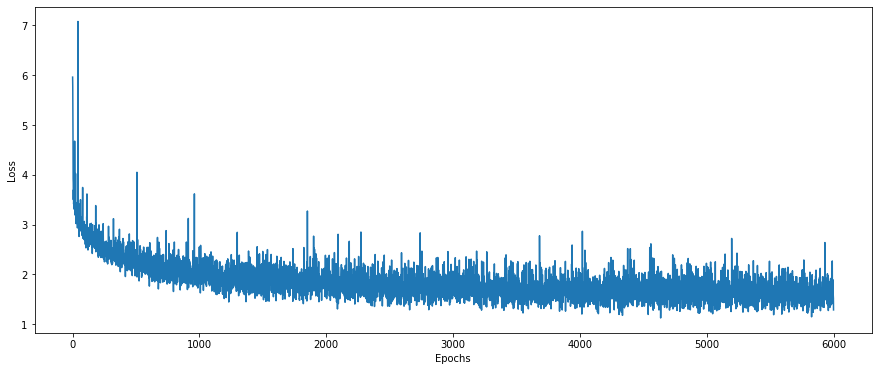

In [ ]:
trainer(model_name = "model_rus6000relu.pth", batch_size=64, epochs=6000, n_layers=2, hidden_size=400)

**Попробовали LSTM**

In [ ]:
class LSTM_model(nn.Module):
  def __init__(self, input_size,hidden_size,output_size, n_layers):
    super(LSTM_model, self).__init__()
    self.input_size = input_size 
    self.hidden_size = hidden_size 
    self.output_size = output_size
    self.n_layers = n_layers
    self.drop_prob = 0.2

    self.encoder = nn.Embedding(self.input_size, self.hidden_size)
    self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
    self.dropout = nn.Dropout(self.drop_prob)
    self.decoder = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden):
    input = self.encoder(input.view(1, -1))
    output, hidden = self.lstm(input.view(1, 1, -1).cuda(), hidden)
    output = self.dropout(output)
    output = self.decoder(output.view(1, -1))
    return output, hidden

  def init_hidden(self):
  # return torch.zeros(self.n_layers, 1, self.hidden_size)
    return (torch.zeros(self.n_layers, 1, self.hidden_size).cuda(),
            torch.zeros(self.n_layers, 1, self.hidden_size).cuda())

Training started...
Loss:  2.6210256958007814
Лри оал лакалае девразбиревы айдим, орезивашилы пррасарабо а менпарая оминю попадане в сороротели они инсиии ирденобном на поддкар е провитуда чиресто» сослетрора ий эфоРаaи спо бен сероналанражичыю порожсяз чтерилет ргачит о калкие и оларсеровова соводалескиленсе  протовамикорана промирежтет гортин
Loss:  2.266306915283203
8то ыизан 2 рагых веричитта оз ганые всечания сочайдом чними воднырицеть и селавцения вПстовеннасту и ковикжествия иризнасстикыповань. В Абрентой подтеромнали вопродат инисазовет сорнствами чта на ботерикижециу нидова в не вазельальния осогопихадани. Вертенованиеншу. В актеровый кобреванном 2н маст-
Loss:  2.532236785888672
я е ае на поспала в еме биреть в доболипант в распраз-проез в.Устолутаст отлеть эторканигиа CД-и полусстих одпетал пволих уличтав, ныком потрочале. Прастогою, стаящени рукдует в на казения, морта киза, стакой в до из постать презутелшие пробиравсти мурссиодам, об в обрениля вырествени распыля тестин
L

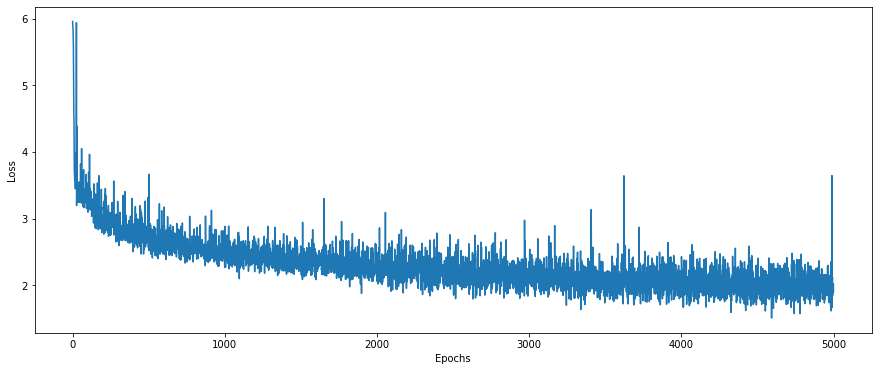

In [ ]:
trainer(model_name = "model_rusLSTM_5000.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=200)

**Результаты LSTM не очень, но близки к основной модели**

# Выводы: 

**Таким образом было обучено достаточное кол-во моделей, модели правильно структурируют предложения, однако смысла в них особо нет, иногда совершаются грамматические ошибки даже на поздних этапах обучения**